In [1]:
%reload_ext autotime
import requests
import requests_cache
requests_cache.install_cache('cache')
import requests_html
import math
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
from pprint import pprint
import re
import traceback
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_colwidth", None)
existing_df = pd.read_excel("givealittle_health.xlsx")
existing_df = existing_df[existing_df.timeLeft == "closed"]
existing_df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
495,Help me support my sick father,Raising money to see my sick father,https://static.givealittle.co.nz/assets/hero/c...,https://givealittle.co.nz/cause/help-me-suppor...,1555.00,2000.0,closed,Read more,https://givealittle.co.nz/cause/help-me-suppor...,20 Oct 2024,27 Oct 2024,0,"Greenhithe, Auckland",39.0,Hey guys. I'm raising money in order to travel...,Travel funds to get from Auckland to Nelson an...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
496,My Cambodian Sister Fighting the Big C,Please help my Cambodian sister fight the big C.,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/my-cambodian-s...,2000.00,3000.0,closed,Read more,https://givealittle.co.nz/cause/my-cambodian-s...,16 Oct 2024,29 Oct 2024,0,Nationwide,26.0,"Last year, Channa was my tour guide in Cambodi...","rent, groceries, transport, and other daily ne...","Created by, and paying to a verified bank acco...",Page Moderated,1.0,Thank you!!!\n1 November 2024\nThank you for o...,NaN
497,Hunter's Top Surgery,Hunter's Top Surgery,https://static.givealittle.co.nz/assets/hero/4...,https://givealittle.co.nz/cause/h-top-surgery-1,1685.00,0.0,closed,Read more,https://givealittle.co.nz/cause/h-top-surgery-1,14 Oct 2024,28 Oct 2024,0,Nationwide,20.0,Hi All!\nI hope everyone is slaying! I know th...,Helping me fund my top surgery!!All funds dona...,"Created by Ayesha Hunwick, paying to a verifie...",Page Moderated,NaN,NaN,NaN
498,Flights needed NZ-London to help 83 year old m...,Raising funds to send a caring daughter to Lon...,https://static.givealittle.co.nz/assets/hero/0...,https://givealittle.co.nz/cause/flights-needed...,0.00,3340.0,closed,Read more,https://givealittle.co.nz/cause/flights-needed...,13 Oct 2024,16 Oct 2024,0,NaN,NaN,My mother has breast cancer and at 83 is havin...,Just the flights,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
499,Help our Beautiful Dad get the Care he Deserves,Help Dad get the treatment he needs,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-our-beaut...,11232.19,0.0,closed,Read more,https://givealittle.co.nz/cause/help-our-beaut...,13 Oct 2024,25 Oct 2024,0,NaN,99.0,We are heartbroken to share that our beloved D...,The costs of going into the Aotearoa Private H...,Created by_x000D_\nFrankie Woods \n\n\n\n_x00...,Page Moderated,1.0,"THANK YOU!\n23 October 2024\nKia ora koutou,\n...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,Amber and Daniel were twins born on 24th and 2...,Raising money for the little McSweeney family ...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/hartleytwinsmi...,4834.00,0.0,closed,Read more,https://givealittle.co.nz/cause/hartleytwinsmi...,2 May 2016,6 Jun 2016,0,Canterbury,122.0,PLEASE READ THE UPDATE TO THIS POST UNDER UPDA...,NaN,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Attention all followers of our story\n31 May 2...,NaN
10414,"Tania Whanau, known by most as Tarnz, is a str...",Since February '16 Tarnz has undergone two ope...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/fightbreastcan...,1550.00,0.0,closed,Read more,https://givealittle.co.nz/cause/fightbreastcan...,1 May 2016,22 Jul 2016,0,Hawke's Bay,34.0,"Tania Whanau, known by most as Tarnz, is a str...",NaN,Created by_x000D_\n _x000D_\n Nanc...,Page Moderated,NaN,NaN,NaN
10415,Cardiology Fundraiser,Fundraising for patients & families affected b...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/fund4aheart,915.00,0.0,closed,Read more,https://givealittle.co.nz/cause/fund4aheart,1 May 2016,15 Aug 2016,0,Waikato,9.0,We aim to provide clients with the m

In [3]:
# takes about 7m without cache.sqlite
URL = "https://givealittle.co.nz/search/api?category=health&showClosed=True&page=cause&sort=newest"
first = requests.get(URL).json()
total = first["total"]
results = first["results"]
last_page = math.ceil(total / len(results))
print(f"Last page: {last_page}")
last_page = min(last_page, 1000)
for page in tqdm(range(2, last_page + 1)):
    try:
        url = f"{URL}&p={page}"
        page_results = requests.get(url).json()
    except Exception as e:
        print(f"Error on page {page}: {e}")
        traceback.print_exc()
        continue
    results.extend(page_results["results"])

Last page: 1314


  0%|          | 0/999 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(results)
df.uri = "https://givealittle.co.nz" + df.uri
df.actionUri = "https://givealittle.co.nz" + df.actionUri
df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri
0,"Rugby league lover, Ben Stowers, has had his w...","This page has been started to help Ben, his pa...",https://static.givealittle.co.nz/assets/hero/8...,https://givealittle.co.nz/cause/rugby-league-l...,3070.0,0.0,362 days to go,Donate,https://givealittle.co.nz/donate/cause/rugby-l...
1,HOPE FOR SUMMER #BATTENSBEATER,An ultra rare Princess who is fighting a rare ...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/hope-for-summe...,585.0,0.0,727 days to go,Donate,https://givealittle.co.nz/donate/cause/hope-fo...
2,Help Esther Fight Breast Cancer — A Young Mum ...,Please help a Vanuatu family through a hard time!,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-esther-fi...,760.0,2100.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/help-es...
3,$100k in 100 days!,Help save a life saving service for mothers in...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/savewellwomen,4779.0,100000.0,110 days to go,Donate,https://givealittle.co.nz/donate/cause/savewel...
4,Goldenhar Syndrome: Help a Young Girl Through ...,"My daughter was born with Goldenhar syndrome, ...",https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/goldenhar-synd...,35.0,30000.0,180 days to go,Donate,https://givealittle.co.nz/donate/cause/goldenh...
...,...,...,...,...,...,...,...,...,...
9994,CJ's fight with progressive brain tumours.,Please help my dad Chris Hall (CJ) fight his p...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/supportcj,24883.0,0.0,closed,Read more,https://givealittle.co.nz/cause/supportcj
9995,Marie needs a little back now,My partner Marie has given so much to others o...,https://static.givealittle.co.nz/assets/hero/8...,https://givealittle.co.nz/cause/makemariewell,70.0,3000.0,closed,Read more,https://givealittle.co.nz/cause/makemariewell
9996,Help Dad Get Through This,"Please help my Dad, so he no longer has to wor...",https://static.givealittle.co.nz/assets/hero/5...,https://givealittle.co.nz/cause/helpgetmydadth...,650.0,0.0,closed,Read more,https://givealittle.co.nz/cause/helpgetmydadth...
9997,Cancer,SPTL Cancer,https://static.givealittle.co.nz/assets/hero/5...,https://givealittle.co.nz/cause/help4will2k17,200.0,0.0,closed,Read more,https://givealittle.co.nz/cause/help4will2k17


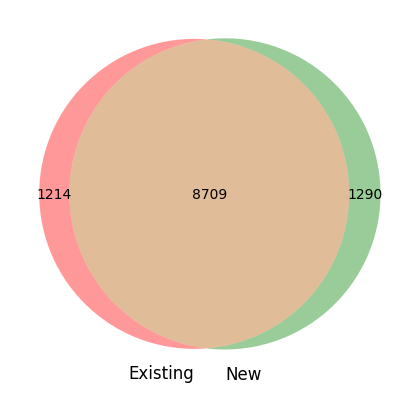

In [6]:
from matplotlib_venn import venn2
venn2([set(existing_df.uri), set(df.uri)], set_labels=["Existing", "New"])

In [7]:
df = df[~df.uri.isin(existing_df.uri)]
df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri
0,"Rugby league lover, Ben Stowers, has had his w...","This page has been started to help Ben, his pa...",https://static.givealittle.co.nz/assets/hero/8...,https://givealittle.co.nz/cause/rugby-league-l...,3070.00,0.0,362 days to go,Donate,https://givealittle.co.nz/donate/cause/rugby-l...
1,HOPE FOR SUMMER #BATTENSBEATER,An ultra rare Princess who is fighting a rare ...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/hope-for-summe...,585.00,0.0,727 days to go,Donate,https://givealittle.co.nz/donate/cause/hope-fo...
2,Help Esther Fight Breast Cancer — A Young Mum ...,Please help a Vanuatu family through a hard time!,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-esther-fi...,760.00,2100.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/help-es...
3,$100k in 100 days!,Help save a life saving service for mothers in...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/savewellwomen,4779.00,100000.0,110 days to go,Donate,https://givealittle.co.nz/donate/cause/savewel...
4,Goldenhar Syndrome: Help a Young Girl Through ...,"My daughter was born with Goldenhar syndrome, ...",https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/goldenhar-synd...,35.00,30000.0,180 days to go,Donate,https://givealittle.co.nz/donate/cause/goldenh...
...,...,...,...,...,...,...,...,...,...
3223,"Help 20,000 New Zealanders suffering from Infl...",Helen hopes to help others shortcut the 16 yea...,https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/help-20000-nze...,3525.00,25000.0,closed,Read more,https://givealittle.co.nz/cause/help-20000-nze...
3331,HELP NEL GET GENDER AFFIRMING TOP SURGERY,I am raising money for gender affirming top su...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/nel-surgery-fund,3514.29,16000.0,closed,Read more,https://givealittle.co.nz/cause/nel-surgery-fund
3362,GET LORA GENDER AFFIRMING SURGERY,I am raising funds for urgent gender affirming...,https://static.givealittle.co.nz/assets/hero/5...,https://givealittle.co.nz/cause/lora-surgery-fund,10987.17,23000.0,closed,Read more,https://givealittle.co.nz/cause/lora-surgery-fund
3479,Eye Care For Africa - Te Araroa 2023 - Lejog (...,Eye Care for Africa is a New Zealand registere...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/eye-care-for-a...,20985.50,0.0,202 days to go,Donate,https://givealittle.co.nz/donate/cause/eye-car...


In [8]:
sum(df.timeLeft == "closed")

776

In [9]:
s = requests_html.HTMLSession()

In [10]:
def extract(row):
    uri = row.uri
    try:
        row = row.to_dict()
        html = s.get(uri).html
        if "This campaign started on" not in html.text:
            start = ""
            end = ""
        else:
            start, end = re.search(r"This campaign started on (.*) and (?:ends|ended) on (.*)\.", html.text).groups()
        question_link = html.find("a[href$=questions]", first=True)
        if question_link.text.strip() in ["Ask a question here", "Ask one here"]:
            n_questions = 0
        elif "One question has been asked already" in html.text:
            n_questions = 1
        else:
            n_questions = int(re.search("(\d+) questions have been asked already", html.text).group(1))
        use_of_funds = html.find("h4", containing="Use of funds", first=True)
        if use_of_funds:
            use_of_funds = use_of_funds.element.getnext().text_content()
        else:
            use_of_funds = ""
        whos_involved = html.find("h4", containing="Who's involved?", first=True)
        if whos_involved:
            whos_involved = whos_involved.element.getnext().text_content().strip()
        else:
            whos_involved = ""
        location = html.find("body > div > div > div.text-gray-600.pb-8.md\:pt-6 > div.w-full.max-w-6xl.mx-auto.px-6.space-y-2 > div.flex.pt-2.md\:pt-0 > div.w-full.md\:w-7\/12.lg\:w-2\/3.md\:shrink-0.space-y-6.divide-y.divide-gray-200 > div:nth-child(1) > p.mt-4", first=True)
        if location:
            location = location.text
        else:
            location = ""
        n_donors = html.find("body > div > div > div.text-gray-600.pb-8.md\:pt-6 > div.w-full.max-w-6xl.mx-auto.px-6.space-y-2 > div.flex.pt-2.md\:pt-0 > div.flex.flex-grow > div > div > div > div.font-serif > div.pt-1 > div > span", first=True)
        if n_donors:
            n_donors = int(n_donors.text)
        else:
            n_donors = ""
        row.update({
            "start": start,
            "end": end,
            "n_questions": n_questions,
            "location": location,
            "n_donors": n_donors,
            "description": html.find("div.break-words", first=True).text,
            "use_of_funds": use_of_funds,
            "whos_involved": whos_involved,
            "moderated": html.find("div.font-semibold")[-1].text
        })
        if "Latest update" in html.text:
            html = s.get(uri + "/updates").html
            updates = html.find("article")
            row.update({
                "n_updates": len(updates),
                "updates": "\n".join([update.text for update in updates])
            })
        if n_questions:
            html = s.get(uri + "/questions").html
            row["Q&A"] = html.find("body > div > div > div.w-full.max-w-6xl.mx-auto.px-6.py-6.text-gray-600.space-y-4 > div > div > div", first=True).text
        return row
    except Exception as e:
        print(f"{e} when trying to extract {uri}")
        print(traceback.format_exc())

df_extracted = pd.json_normalize(df.progress_apply(extract, axis=1))
df_extracted

  0%|          | 0/1290 [00:00<?, ?it/s]

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
0,"Rugby league lover, Ben Stowers, has had his w...","This page has been started to help Ben, his pa...",https://static.givealittle.co.nz/assets/hero/8...,https://givealittle.co.nz/cause/rugby-league-l...,3070.00,0.0,362 days to go,Donate,https://givealittle.co.nz/donate/cause/rugby-l...,9 Jun 2025,8 Jun 2026,0,"Porirua, Wellington",52,On the 22nd of March Ben's life took a turn fo...,"Travel between Wellington and Christchurch, da...",Created by\r\nKarra Hanara \n\n\n\n\r\n ...,Page Moderated,NaN,NaN,NaN
1,HOPE FOR SUMMER #BATTENSBEATER,An ultra rare Princess who is fighting a rare ...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/hope-for-summe...,585.00,0.0,727 days to go,Donate,https://givealittle.co.nz/donate/cause/hope-fo...,9 Jun 2025,9 Jun 2027,0,Nationwide,14,Summer is 11 years old with a rare terminal Di...,Medical costs medical equipment costs making m...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,A little something about Summer 🦄\n11 June 202...,NaN
2,Help Esther Fight Breast Cancer — A Young Mum ...,Please help a Vanuatu family through a hard time!,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-esther-fi...,760.00,2100.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/help-es...,8 Jun 2025,22 Jun 2025,0,"Cromwell, Otago",16,"This fundraiser is for Esther, a strong and lo...",To Esther treatment in india,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Update on Esther – Thank You for Your Support\...,NaN
3,$100k in 100 days!,Help save a life saving service for mothers in...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/savewellwomen,4779.00,100000.0,110 days to go,Donate,https://givealittle.co.nz/donate/cause/savewel...,8 Jun 2025,30 Sep 2025,0,Auckland,63,"At Well Women Trust, we walk alongside women t...","Well Women Trust needs to raise $100,000 withi...","Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
4,Goldenhar Syndrome: Help a Young Girl Through ...,"My daughter was born with Goldenhar syndrome, ...",https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/goldenhar-synd...,35.00,30000.0,180 days to go,Donate,https://givealittle.co.nz/donate/cause/goldenh...,8 Jun 2025,8 Dec 2025,0,Nationwide,3,"In 2010, my daughter was born with Goldenhar S...",Ongoing medical costs. Every sent will be put ...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,"Help 20,000 New Zealanders suffering from Infl...",Helen hopes to help others shortcut the 16 yea...,https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/help-20000-nze...,3525.00,25000.0,closed,Read more,https://givealittle.co.nz/cause/help-20000-nze...,12 Dec 2022,12 Dec 2024,0,Auckland,34,I was 28 when I was diagnosed with Crohn's dis...,Funds will be used to create a website to hous...,Created by\r\nAmy Shaw \n\n\n\n\n\n\r\n ...,Page Moderated,7.0,"Swimming\n4 July 2023\nHi everyone, I have som...",NaN
1286,HELP NEL GET GENDER AFFIRMING TOP SURGERY,I am raising money for gender affirming top su...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/nel-surgery-fund,3514.29,16000.0,closed,Read more,https://givealittle.co.nz/cause/nel-surgery-fund,14 Nov 2022,14 Nov 2024,0,Wellington,44,Kia Ora\nI started my medical transition in Oc...,All money that is donated will go toward my to...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Update 28/03/24 - Change of Plans ✈️ 🇹🇭🏳️‍⚧️\n...,NaN
1287,GET LORA GENDER AFFIRMING SURGERY,I am raising funds for urgent gender affir

In [11]:
df_extracted = pd.concat([df_extracted, existing_df], ignore_index=True)
df_extracted

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
0,"Rugby league lover, Ben Stowers, has had his w...","This page has been started to help Ben, his pa...",https://static.givealittle.co.nz/assets/hero/8...,https://givealittle.co.nz/cause/rugby-league-l...,3070.0,0.0,362 days to go,Donate,https://givealittle.co.nz/donate/cause/rugby-l...,9 Jun 2025,8 Jun 2026,0,"Porirua, Wellington",52,On the 22nd of March Ben's life took a turn fo...,"Travel between Wellington and Christchurch, da...",Created by\r\nKarra Hanara \n\n\n\n\r\n ...,Page Moderated,NaN,NaN,NaN
1,HOPE FOR SUMMER #BATTENSBEATER,An ultra rare Princess who is fighting a rare ...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/hope-for-summe...,585.0,0.0,727 days to go,Donate,https://givealittle.co.nz/donate/cause/hope-fo...,9 Jun 2025,9 Jun 2027,0,Nationwide,14,Summer is 11 years old with a rare terminal Di...,Medical costs medical equipment costs making m...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,A little something about Summer 🦄\n11 June 202...,NaN
2,Help Esther Fight Breast Cancer — A Young Mum ...,Please help a Vanuatu family through a hard time!,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-esther-fi...,760.0,2100.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/help-es...,8 Jun 2025,22 Jun 2025,0,"Cromwell, Otago",16,"This fundraiser is for Esther, a strong and lo...",To Esther treatment in india,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Update on Esther – Thank You for Your Support\...,NaN
3,$100k in 100 days!,Help save a life saving service for mothers in...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/savewellwomen,4779.0,100000.0,110 days to go,Donate,https://givealittle.co.nz/donate/cause/savewel...,8 Jun 2025,30 Sep 2025,0,Auckland,63,"At Well Women Trust, we walk alongside women t...","Well Women Trust needs to raise $100,000 withi...","Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
4,Goldenhar Syndrome: Help a Young Girl Through ...,"My daughter was born with Goldenhar syndrome, ...",https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/goldenhar-synd...,35.0,30000.0,180 days to go,Donate,https://givealittle.co.nz/donate/cause/goldenh...,8 Jun 2025,8 Dec 2025,0,Nationwide,3,"In 2010, my daughter was born with Goldenhar S...",Ongoing medical costs. Every sent will be put ...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11208,Amber and Daniel were twins born on 24th and 2...,Raising money for the little McSweeney family ...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/hartleytwinsmi...,4834.0,0.0,closed,Read more,https://givealittle.co.nz/cause/hartleytwinsmi...,2 May 2016,6 Jun 2016,0,Canterbury,122.0,PLEASE READ THE UPDATE TO THIS POST UNDER UPDA...,NaN,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Attention all followers of our story\n31 May 2...,NaN
11209,"Tania Whanau, known by most as Tarnz, is a str...",Since February '16 Tarnz has undergone two ope...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/fightbreastcan...,1550.0,0.0,closed,Read more,https://givealittle.co.nz/cause/fightbreastcan...,1 May 2016,22 Jul 2016,0,Hawke's Bay,34.0,"Tania Whanau, known by most as Tarnz, is a str...",NaN,Created by_x000D_\n _x000D_\n Nanc...,Page Moderated,NaN,NaN,NaN
11210,Cardiology Fundraiser,Fundraising for patients & families affected b...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/fund4aheart,915.0,0.0,closed,Read more,https://givealittle.co.n

In [12]:
df_extracted.to_excel("givealittle_health.xlsx", index=False)